- 코드 참고: 도서 <실전! 딥러닝(위키북스)>

- 모듈 임포트 및 구글드라이브 마운트

In [49]:
import warnings
warnings.filterwarnings('ignore')

import os, glob, math, random, cv2
import numpy as np
import matplotlib.pyplot as plt

from tensorflow.keras.preprocessing.image import load_img, img_to_array, array_to_img
from tensorflow.keras.models import load_model

from IPython.display import display_png
from PIL import Image

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

### @@@데이터 폴더로 이동하기@@@

In [ ]:
# '.../세미(2) 프로젝트/NEWDATA/'로 이동하기
%cd /content/drive/MyDrive/04 멀캠/세미(2) 프로젝트/NEWDATA

### @@@포켓몬 설정하기@@@

In [4]:
print('내 포켓볼 --> 0.이상해씨 1.잠만보 2.이브이 3.파이리 4.꼬부기 5.피카츄 6.지우 7.이슬이')
idx = int(input('너로 정했다~!(번호 입력) --> '))

내 포켓볼 --> 0.이상해씨 1.잠만보 2.이브이 3.파이리 4.꼬부기 5.피카츄 6.지우 7.이슬이
너로 정했다~!(번호 입력) --> 2


### @@@전역 변수 설정하기@@@

In [5]:
## 전역 변수

categories = ['isang', 'jammanbo', 'evee', 'pie', 'squirtle', 'pikachu', 'jiwoo', 'leeseul']
img_size = 128
batch_size = 30
epochs = 3000
monitor = 'val_accuracy'
data_path = categories[idx]

In [6]:
## 함수

# RGB -> LAB 이미지로 변환
def rgb2lab(rgb):
    assert rgb.dtype == 'uint8'
    return cv2.cvtColor(rgb, cv2.COLOR_RGB2Lab)

# LAB -> RGB 이미지로 변환
def lab2rgb(lab):
    assert lab.dtype == 'uint8'
    return cv2.cvtColor(lab, cv2.COLOR_Lab2RGB)

# data_list 내 RGB 이미지를 LAB array로 반환
def get_lab_from_data_list(data_list):
    x_lab = []
    for f in data_list:
        rgb = img_to_array(load_img(f, target_size=(img_size, img_size))).astype(np.uint8)    # RGB 이미지를 128*128 사이즈로 불러와 array로 변환
        lab = rgb2lab(rgb)    # RGB array -> LAB array로 변환
        x_lab.append(lab)     # LAB array를 리스트에 저장
    return np.stack(x_lab)    # 리스트를 array로 변환

In [7]:
# 위 셀의 3가지 함수를 활용한 최종 함수
# data_list 내 RGB 이미지를 generator(L array, AB array)로 반환
# generator 1개 당 이미지 batch_size개
def generator_with_preprocessing(data_list, batch_size, shuffle=False):
    while True:
        if shuffle:
            np.random.shuffle(data_list)                      # 데이터 순서 섞기
        for i in range(0, len(data_list), batch_size):
            batch_list = data_list[i:i + batch_size]          # batch_size만큼 이미지 가져오기
            batch_lab = get_lab_from_data_list(batch_list)    # 이미지 LAB array로 변환
            batch_l = batch_lab[:, :, :, 0:1]                 # L 값만 추출 -> (batch_size, 128, 128, 1)
            batch_ab = batch_lab[:, :, :, 1:]                 # AB 값만 추출 -> (batch_size, 128, 128, 2)
            yield (batch_l, batch_ab)

# 베스트 모델 불러와 예측하기(컬러값 얻기)
### - 입력데이터: 손그림에 흑백음영을 추가한 GAN 이미지
### - 예측데이터: 컬러값(AB)

- GAN 이미지 불러와 generator 생성

In [50]:
GAN_path = 'Colorize/' + data_path
GAN_lists = glob.glob(os.path.join(GAN_path, '*.jpg'))
GAN_gen = generator_with_preprocessing(GAN_lists, batch_size)
GAN_steps = math.ceil(len(GAN_lists)/batch_size)

print(f'GAN data: {len(GAN_lists)}개')
print(GAN_lists)

GAN data: 3개
['Colorize/evee/eevee_pre_20.jpg', 'Colorize/evee/eevee_pre_30.jpg', 'Colorize/evee/eevee_pre_50.jpg']


- GAN 이미지 채색하기

In [41]:
# 베스트 모델 불러오기
best_model_path = data_path + '_coloring_best_epochs' + str(epochs) + '_' + monitor + '.h5'
best_model = load_model('Colorize/model/' + best_model_path)
GAN_preds = best_model.predict_generator(GAN_gen, steps=GAN_steps)  # GAN AB

# 1. GAN AB + GAN L

In [42]:
# GAN L 추출
x_GAN = []

for i, (l, _) in enumerate(GAN_gen):
    x_GAN.append(l)
    if i == (GAN_steps - 1):
        break
        
x_GAN = np.vstack(x_GAN)

In [43]:
# GAN L과 GAN AB를 결합하여 LAB array 생성 -> RGB로 변환
GAN_preds_lab = np.concatenate((x_GAN, GAN_preds), 3).astype(np.uint8)

GAN_preds_rgb = []
for i in range(GAN_preds_lab.shape[0]):
    preds_rgb = lab2rgb(GAN_preds_lab[i, :, :, :])
    GAN_preds_rgb.append(preds_rgb)
GAN_preds_rgb = np.stack(GAN_preds_rgb)

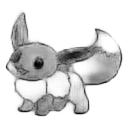

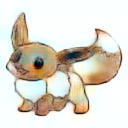

-------------------------


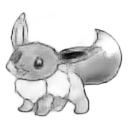

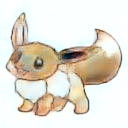

-------------------------


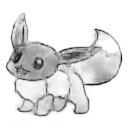

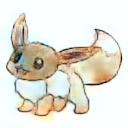

-------------------------


In [44]:
# GAN 이미지 & 채색 결과 함께 출력
for i in range(GAN_preds_lab.shape[0]):
    img = Image.open(GAN_lists[i]).resize((img_size, img_size))
    display_png(img)
    display_png(array_to_img(GAN_preds_rgb[i]))
    print('-'*25)
    if i == 20:
        break

# 2. GAN AB + 손그림 L

In [45]:
handwriting_path = 'Colorize/handwriting/' + data_path
handwriting_lists = glob.glob(os.path.join(handwriting_path, '*.jpg'))
handwriting_gen = generator_with_preprocessing(handwriting_lists, batch_size)
handwriting_steps = math.ceil(len(handwriting_lists)/batch_size)

print(f'Handwriting data: {len(handwriting_lists)}개')

Handwriting data: 3개


In [46]:
# 손그림 L 추출
x_handwriting = []

for i, (l, _) in enumerate(handwriting_gen):
    x_handwriting.append(l)
    if i == (handwriting_steps - 1):
        break
        
x_handwriting = np.vstack(x_handwriting)

In [47]:
# 손그림 L과 GAN AB를 결합하여 LAB array 생성 -> RGB로 변환
handwriting_preds_lab = np.concatenate((x_handwriting, GAN_preds), 3).astype(np.uint8)

handwriting_preds_rgb = []
for i in range(handwriting_preds_lab.shape[0]):
    preds_rgb = lab2rgb(handwriting_preds_lab[i, :, :, :])
    handwriting_preds_rgb.append(preds_rgb)
handwriting_preds_rgb = np.stack(handwriting_preds_rgb)

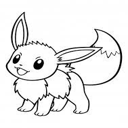

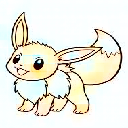

-------------------------


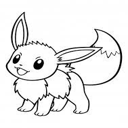

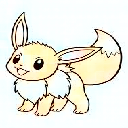

-------------------------


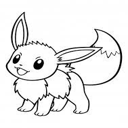

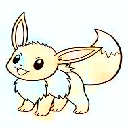

-------------------------


In [48]:
# 손그림 이미지 & 채색 결과 함께 출력
for i in range(handwriting_preds_lab.shape[0]):
    img = Image.open(handwriting_lists[i]).resize((img_size, img_size))
    display_png(img)
    display_png(array_to_img(handwriting_preds_rgb[i]))
    print('-'*25)
    if i == 20:
        break